#Putting it all together: exploratory bioinformatics with matplotlib

####About the author:
Oxana is a data scientist based in Stockholm, Sweden. She is studying for a PhD in Bioinformatics, exploring molecular evolution patterns in eukaryotes. You can follow Oxana on Twitter [@Merenlin](http://twitter.com/Merenlin) or read [her blog](http://merenlin.com).

###Introduction
This notebook will give you the recipes of the most popular data visualizations I encounter in my work as a bioinformatician. If you always wondered what bioinformatics is all about or would like to create interactive
visualization for your genomic data using [matplotlib](http://matplotlib.org/), this is the place to start. 

We will be working with real [gene expression](http://en.wikipedia.org/wiki/Gene_expression) data obtained by [Cap Analysis of Gene Expression(CAGE)](http://en.wikipedia.org/wiki/Cap_analysis_gene_expression) from human samples by the [FANTOM5](http://fantom.gsc.riken.jp/5/) consortium. We will be following a typical workflow of a bioinformatician exploring new data, looking for the outliers: interesting genes or samples, or general patterns in the data. 

### Obtaining the data

FANTOM5 provides high precision data of thousands of human and mouse samples. The vastness of this data can be overwhelming and operating it locally is challenging. Luckily, there are many tools out there to make our life easier.  
For creating a small data subset we can work with in this tutorial, I used [TET: Fantom 5 Table Extraction tool](http://fantom.gsc.riken.jp/5/tet). I picked a few human samples, mostly brain tissues with a few outliers, like uterus and downloaded a tab-separated file from the website. For more advanced data extraction, it's good to have a look at [TET's API](https://github.com/Hypercubed/TET/blob/master/README.md). 
I have picked normalized tpm(tags per million) and annotated data, so we can focus only on processed data for protein coding genes. All data files for this notebook are available on figshare: http://dx.doi.org/10.6084/m9.figshare.1430029

###Loading the dataset

We are loading the data from the .tsv file, skipping the first two columns (00Annotation and short_description).

In [2]:
import numpy as np
import pandas as pd

#%load hg19.cage_peak_tpm_ann_decoded.osc.txt.gz.extract.tsv

# Read data from a tab separated file you downloaded
data = np.genfromtxt("hg19.tsv"
                     ,comments="#",names=True,dtype=object,delimiter="\t")

df = pd.DataFrame(data)

# This seems to work well to, i will use df_2 now
df_2 = pd.read_table('hg19.tsv')

#print it out, make sure the expression data is of type float

#first have a look at the dataframe
df_2

#the expression data starts at column index 3 and on
df_2[df_2.columns[3:]]

#we make those values floats and look at df again
df_2[df_2.columns[3:]] = df_2[df_2.columns[3:]].astype(float)
df_2

#print out how many genes there are in your dataset
#here we can count e.g. uniprot_id lines
df_2['uniprot_id'].describe()
#there were 184827 genes

#look at df_2 again
df_2.head()


,description,association_with_transcript,uniprot_id,"Adipocyte - breast, donor1 CNhs11051.11376-118A8","Adipocyte - omental, donor1 CNhs11054.11473-119C6","Amniotic Epithelial Cells, donor1 CNhs11341.11533-120A3","Amniotic Epithelial Cells, donor3 CNhs12125.11694-123A2","B lymphoblastoid cell line: GM12878 ENCODE, biol_rep1 CNhs12331.10821-111C2","B lymphoblastoid cell line: GM12878 ENCODE, biol_rep2 CNhs12332.10822-111C3","CD14+ Monocytes, donor1 CNhs10852.11224-116B9","CD14+ Monocytes, donor2 CNhs11954.11305-117B9","CD19+ B Cells (pluriselect), donor090309, donation1 CNhs12177.12189-129B2","CD19+ B Cells (pluriselect), donor090309, donation2 CNhs12179.12194-129B7","CD4+CD25+CD45RA+ naive regulatory T cells expanded, donor1 CNhs13203.11793-124C2","CD4+CD25+CD45RA+ naive regulatory T cells, donor1 CNhs13238.11780-124A7"
0,"CAGE_peak_at_chr10:100013403..100013414,-",NaN,NaN,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.0,0,0,0.00,0
1,CAGE_peak_1_at_LOXL4_5end,"48bp_to_ENST00000260702,NM_032211,uc001kpa.1_5end",uniprot:Q96JB6,1.09,2.40,0.22,0.53,0.00,0.00,0.00,0.0,0,0,0.00,0
2,"CAGE_peak_at_chr10:100076685..100076699,+",NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.55,0.4,0,0,0.00,0
3,"CAGE_peak_at_chr10:100150910..100150935,-",NaN,NaN,0.00,0.00,0.00,0.00,0.15,0.08,0.00,0.0,0,0,0.17,0
4,"CAGE_peak_at_chr10:100150951..100150962,-",NaN,NaN,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.0,0,0,0.00,0


 Let's also make sure that we filter out those genes for which the [Uniprot](http://www.uniprot.org/) Id is unknown. That will reduce our data, besides, we are only interested in proteins in this analysis. 

In [3]:
# Remove rows from the data frame for which uniprot_id column is b'NA' or '' 

#this removes null elements
df_2 = df_2[df_2['uniprot_id'].notnull()]

# Print out the first 5-10 rows of the dataframe again
df_2.head()

,description,association_with_transcript,uniprot_id,"Adipocyte - breast, donor1 CNhs11051.11376-118A8","Adipocyte - omental, donor1 CNhs11054.11473-119C6","Amniotic Epithelial Cells, donor1 CNhs11341.11533-120A3","Amniotic Epithelial Cells, donor3 CNhs12125.11694-123A2","B lymphoblastoid cell line: GM12878 ENCODE, biol_rep1 CNhs12331.10821-111C2","B lymphoblastoid cell line: GM12878 ENCODE, biol_rep2 CNhs12332.10822-111C3","CD14+ Monocytes, donor1 CNhs10852.11224-116B9","CD14+ Monocytes, donor2 CNhs11954.11305-117B9","CD19+ B Cells (pluriselect), donor090309, donation1 CNhs12177.12189-129B2","CD19+ B Cells (pluriselect), donor090309, donation2 CNhs12179.12194-129B7","CD4+CD25+CD45RA+ naive regulatory T cells expanded, donor1 CNhs13203.11793-124C2","CD4+CD25+CD45RA+ naive regulatory T cells, donor1 CNhs13238.11780-124A7"
1,CAGE_peak_1_at_LOXL4_5end,"48bp_to_ENST00000260702,NM_032211,uc001kpa.1_5end",uniprot:Q96JB6,1.09,2.40,0.22,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,CAGE_peak_1_at_PYROXD2_5end,"0bp_to_ENST00000370575,ENST00000462874_5end",uniprot:Q8N2H3,4.91,5.07,13.11,10.02,0.31,0.57,1.11,1.00,0.00,0.55,4.01,4.89
7,CAGE_peak_2_at_PYROXD2_5end,"0bp_to_NM_032709,uc001kpc.2,uc001kpd.2,uc010qp...",uniprot:Q8N2H3,2.36,1.97,3.50,3.43,0.15,0.16,0.00,0.00,0.00,0.00,0.67,1.30
14,CAGE_peak_1_at_HPS1_5end,"0bp_to_ENST00000325103,ENST00000338546,ENST000...","uniprot:Q92902,uniprot:Q658M9,uniprot:Q8WXE5",46.51,37.07,42.81,39.04,27.13,24.38,50.41,48.33,54.56,48.61,36.28,35.53
23,CAGE_peak_1_at_HPSE2_5end,84bp_to_AJ299720_5end,uniprot:Q8WWQ2,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


###1. MA scatter plot comparing newborn and adult tissues

[MA plot](http://en.wikipedia.org/wiki/MA_plot) is a popular visualization tool coming from the microarray analysis. It allows researchers to explore true statistical differences between the two samples, arrays or other observations. We are going to look at the two samples of substantia nigra tissues from the brain of an adult and a newborn person. How do their genetic profiles differ? 

Firs, let's subset our big dataframe to only include the samples of interest. We will also prefilter the data to not include genes that are not expressed in these tissues. 


In [4]:
# pick two columns of the dataframe that makes sense to compare
# I choose the values in column 4 and 5 i.e. index 3 and 4

df_MA = df_2[[3,4]]
df_MA = df_MA[(df_MA.T != 0).any()]  #remove rows with all zeros
df_MA.head()



,"Adipocyte - breast, donor1 CNhs11051.11376-118A8","Adipocyte - omental, donor1 CNhs11054.11473-119C6"
1,1.09,2.40
6,4.91,5.07
7,2.36,1.97
14,46.51,37.07
29,0.55,0.28


There are many different methods of computing the average expression level(A) between the two observations and
the mean variation(M). To keep things simple, for this example we will just compare the mean avg on the x-axis vs the minus on the y-axis.
Our data is already normalized and preprocessed, so this will be enough to find the clear outliers. 

Don't forget to plot on the log scales on both axis.

/Users/olovsvartstrom/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


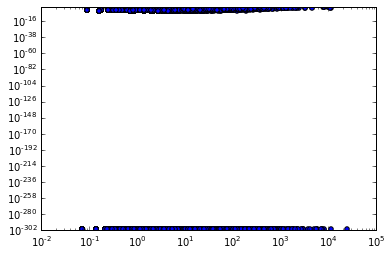

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

#first make x and y to numpyarrays from values for computations
x = np.array(df_MA['Adipocyte - breast, donor1 CNhs11051.11376-118A8'].values)
y = np.array(df_MA['Adipocyte - omental, donor1 CNhs11054.11473-119C6'].values)

#when they are numpyarrays we can perform these operations directly like below and put them in A and M
A = (x + y)/2
M = x - y

#then scatter printing 
#something is wrong though
#it seems to be zero values
plt.xscale('log')
plt.yscale('log')
plt.scatter(A,M)

#Plot a scatter plot of M vs A

Now we can already start exploring some of the genes, that behave differently in adult vs newborn samples. 

### 2. Histograms of expression breadth and average expression levels

Another timeless visualization for exploratory data analysis is histogram.

Here we will also practice creating subplots.

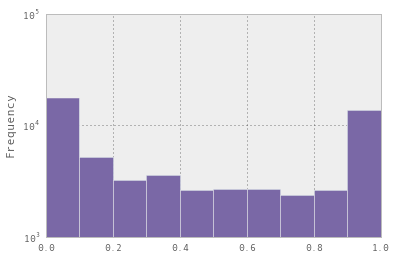

In [6]:
df_2['breadth'] =  (df_2[df_2.columns[3:].values.tolist()].astype('float')>0).sum(axis=1)

#compute average expression column. Im guessing that mean works. I also examined some values and it looked good
df_2['avg'] =  (df_2[df_2.columns[3:14].values.tolist()].astype('float')>0).mean(axis=1)
df_2['avg']

df_2.head()

pd.options.display.mpl_style = 'default'

#df_BR = df_2['breadth']
#df_BR.plot(kind='hist')

df_AVG = df_2['avg']
df_AVG.plot(kind='hist')

plt.yscale('log')
df_AVG = df_2['avg']
df_AVG.plot(kind='hist')

# plot two subplots of histograms of breadth and avg columns, use pandas tools only ;)
# try with and without log scale

Here is where interactive visualization comes in handy. Average expression level distribution looks very wide because of a few outliers, - highly expressed genes and most of the genes actually being expressed at a very low level. But instead of trying to adjust the limits on the x-axis, we can just zoom in on the interesting area. Try it!

### 3. Scatter plot with a trend line

This kind of plot must be the most popular way to visualize a trend in biological data. We seek clear
and simple patterns demonstrating the relationships between different biological parameters or observations.
Plot.ly's Python API does not come with out-of-the-box tools for plotting trend lines, but numpy has all we need. 

Let's say we want to plot the relationship between the breadth of expression and the average level. Again, for speed and simplicity, we only take the first 1000 genes in our data frame. Let's try to fit a polinomial function to our data points and plot both at the same time. By using plot.ly it's simple, just send the regression line trace to the same figure.  

/Users/olovsvartstrom/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


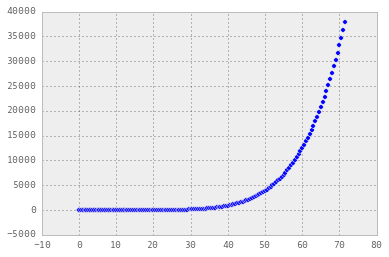

In [7]:
# Plot a scatter plot of the relationship betwen breadth of expression and avg with a trend line

df_BRE = df_2['breadth']
df_BRE = df_BRE.head(1000)
df_AVG = df_2['avg']
df_AVG = df_AVG.head(1000)

x = np.array(df_BRE.values)
y = np.array(df_AVG.values)

# Tips utilized for trend line
coefficients = np.polyfit(x, y, 6)
polynomial = np.poly1d(coefficients)
r_x = np.arange(0, 72, 0.5) # returns evenly spaced values within a given interval.
r_y = polynomial(r_x)

#normal scatter plot
plt.scatter(x,y)

#regression line
plt.scatter(r_x,r_y)


### 4. Heatmap of gene expression

Heatmap is another great way to visualize big amounts of data. It allows to clearly see the outliers and explore the 
general clustering patterns. Are genes in different tissues, but the same donor expressed similarly or do the same tissues
from different donors tend to cluster together? Do brains of newborns and adults differ in gene expression patterns? 
Heatmaps of gene expression can give you good leads to questions like these. 

There is one catch with generating a heatmap for biological samples using plot.ly. Labels of the heatmap will actually
be coordinates on the x and y axis. For the plot to look less cluttered, I have removed the grid and set dtick to 1. Setting autotick to False also proved useful in order to see all the samples correctly labeled. 

To improve readability, one often also needs to process samples names. In our data, as you probably noticed, sample names include everything: tissue name, annotation, donor, age. The name becomes long and impossible to display in a plot. Simple shortening will not work with plot.ly though, since the coordinates must be unique! 

For this tutorial I've cheated a bit, by just adding an integer to each shortened name, I'm sure you can handle the string processing of your samples names on your own ;-)

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Shorten names 
cols = [col for col in df_2.columns if col not in ['breadth', 'uniprot_id', 'avg']]
short_cols = [col[0:20] for col in cols]
short_cols = [str(i) for i in range(1,len(short_cols)-1,1)]
df_2_short = df_2

first_elements = df_2_short.columns[0:3].tolist()
last_elements = [df_2_short.columns[-2] , df_2_short.columns[-1]]
all_short_cols = first_elements + short_cols + last_elements
df_2_short.columns

df_2_short.columns = all_short_cols

df2heat = df_2_short[df_2_short.columns[3:15]]
df2heat


#Compute a distance matrix between columns and save it in square form
distance_matrix = squareform(pdist(df2heat))

# plot a heatmap
plt.pcolor(distance_matrix)
plt.yticks(np.arange(0.5, len(distance_matrix.index), 1), distance_matrix.index)
plt.xticks(np.arange(0.5, len(distance_matrix.columns), 1), distance_matrix.columns)
plt.show(distance_matrix)

### 5. Network of gene interactions

Now at some point in our biological investigations, we've got to dig deeper and look at concrete genes/proteins we found interesting. 

If you go back to our first plot, you'll see that one of the points that stand out corresponds to Q16352(Alpha-internexin, AINX_HUMAN). This gene demonstrates both high level of expression in substantia nigra and the difference between adult and newborn samples is also significant. Which kind of makes sense, since this protein is involved in the morphogenesis of neurons. One of the ways to find out more about a protein is to look at it's interaction networks. 

I've downloaded the interaction network in tab-separated format from a popular database [string-db.org](http://string-db.org/), so there is nothing novel in plotting it, we are merely reproducing the graph on their website, but, hopefully, you'll be able to use it for your future contributions to science! 

In [10]:
import networkx as nx

#x = np.genfromtxt('http://figshare.com/download/file/2088824', delimiter="\t", names=True, usecols=[0,1,14],
#                  dtype=['S5','S5','f8'])
#labels = x.dtype.names

# Create an empty graph
# G =  

# Add edges to it from x

# Plot G

Now you see our protein under it's gene name(INA) in the center of the graph. 

Now, that's all, folks! I hope you enjoyed this intro to exploratory bioinformatics and got inspired to create beautiful interactive visualizations for your biological data. 